In [1]:
import pandas as pd 
import numpy as np
import os
from joblib import dump
import pickle as pkl
import pickle
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_recall_curve
from sklearn.metrics import make_scorer, fbeta_score,  mean_squared_error, r2_score, f1_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, precision_recall_curve, classification_report, confusion_matrix)
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn import datasets
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

In [ ]:
import pickle
#with open('random_search_results.pkl', 'wb') as file:
#    pickle.dump(random_search, file)

with open('random_search_results.pkl', 'rb') as file:
    cv_results = pickle.load(file)

with open('full_gridsearch.pkl', 'rb') as file:
    cv_results = pickle.load(file)

In [2]:
train_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/train_df.csv')
eval_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/eval_df.csv')
test_df = pd.read_csv('/work/SarahHvidAndersen#6681/DataScience_project/data/test_df.csv')

selected_features = ['Fwd IAT Total', 'Fwd Packet Length Max',
        'Bwd Packet Length Mean', 'Bwd Packet Length Std',
        'Bwd Packets Length Total', 'Bwd Packet Length Max',
        'Packet Length Max', 'Packet Length Mean', 'Packet Length Std',
        'Packet Length Variance', 'Avg Packet Size', 'Fwd Header Length',
        'Avg Fwd Segment Size', 'Avg Bwd Segment Size']

X_train = train_df[selected_features]  # Features from the training data
y_train = train_df['Attack'] 

X_eval = eval_df[selected_features]  # Features from the evaluation data
y_eval = eval_df['Attack']

X_test = test_df[selected_features]
y_test = test_df['Attack']

In [3]:
# Initialize scaler
scaler = StandardScaler()

# Scale the features
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])

# Applying the 'trained' scaler on eval and test
X_eval[X_eval.columns] = scaler.transform(X_eval[X_eval.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

/tmp/ipykernel_3171/809619830.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
/tmp/ipykernel_3171/809619830.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_eval[X_eval.columns] = scaler.transform(X_eval[X_eval.columns])
/tmp/ipykernel_3171/809619830.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

# random forest grid search

In [ ]:
# gridsearch f1 - randomized iter
# Define the model
rf = RandomForestClassifier(random_state=42) 

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup stratified cross-validation
cv = StratifiedKFold(n_splits=5)

# Define the scorer, F1 Score
f1_scorer = make_scorer(f1_score, average='binary')

# Setup the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, scoring=f1_scorer, cv=cv, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

In [ ]:
# gridsearch f2 - randomized  - 11 minutes

# Define the model
rf = RandomForestClassifier(random_state=42) 
# Setup stratified cross-validation
cv = StratifiedKFold(n_splits=5)

# Define the parameter grid
random_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#max_depth: 40 70 n_estimators = 200, min samples split = 2-5, min leaf = 1-2 
# using random search 1 = Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 30}
#Best F2 Score: 0.8911214118776313
#Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 15, 'max_depth': 70}

# Define the scorer, F2 Score, could be too high, maybe experiment with F1.5
f2_scorer = make_scorer(fbeta_score, beta=2, average='binary')

# Setup the RandomizedSearchCV
# randomized search samples combination from the param_grid
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, scoring=f2_scorer, cv=cv, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

In [ ]:
print("Best Parameters:", random_search.best_params_)
print("Best F2 Score:", random_search.best_score_)
results = random_search.cv_results_

# using random search 1 = Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 30}
#Best F2 Score: 0.8911214118776313

# max_depth: 40 70 n_estimators = 200, min samples split = 2-5, min leaf = 1-2 

In [ ]:
# gridsearch f2 - all

# Define the model
rf = RandomForestClassifier(random_state=42) 
# Setup stratified cross-validation
cv = StratifiedKFold(n_splits=5)

param_grid = {
    'n_estimators': [90, 100, 110],
    'max_depth': [30, 40, 50, 60, 70],
    'min_samples_split': [5, 8, 10],
    'min_samples_leaf': [1, 2]
}

# Define the scorer, F2 Score, could be too high, maybe experiment with F1.5
f2_scorer = make_scorer(fbeta_score, beta=2, average='binary')

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=f2_scorer, cv=cv, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best F2 Score:", grid_search.best_score_)
results = grid_search.cv_results_

#Best Parameters: {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 110}
#Best F2 Score: 0.8911617330784429

In [ ]:
# 'results' is obtained from random_search.cv_results_
#with open('full_gridsearch.pkl', 'rb') as file:
#    results = pickle.load(file)

scores_matrix = pd.DataFrame({
    'score': results['mean_test_score'],
    'min_samples_split': results['param_min_samples_split'],
    'n_estimators': results['param_max_depth']
})

# Create a pivot table using pivot_table method to handle duplicates
pivot_table = scores_matrix.pivot_table(index='min_samples_split', columns='n_estimators', values='score', aggfunc='mean')

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title('Grid Search Scores')
plt.xlabel('miax features')
plt.ylabel('Min samples')
plt.show()

In [ ]:

scores_matrix = pd.DataFrame({
    'score': results['mean_test_score'],
    'min_samples_split': results['param_min_samples_split'],
    'min_samples_leaf': results['param_min_samples_leaf'],
    'n_estimators': results['param_n_estimators'],
    'max_depth': results['param_max_depth']
})

# Parameter combinations to plot
params = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']
n = len(params)

# Create a subplot grid
fig, axes = plt.subplots(n, n, figsize=(15, 15))

# Avoid duplicate heatmaps
for i in range(n):
    for j in range(i + 1, n):
        # Pivot table for the current pair of parameters
        pivot_table = scores_matrix.pivot_table(
            index=params[i], columns=params[j], values='score', aggfunc='mean')
        
        # Heatmap
        sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", ax=axes[i, j])
        axes[i, j].set_title(f'{params[i]} vs {params[j]}')
        axes[i, j].set_xlabel(params[j])
        axes[i, j].set_ylabel(params[i])

        # Hide axes where there are no plots
        if j != i + 1:
            axes[j, i].axis('off')

# Adjust layout for tight fit
plt.tight_layout()
plt.show()

# xgboost

In [ ]:

# Define the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'gamma': [0, 0.1, 0.5, 1, 1.5, 2]
}

# Setup stratified cross-validation
cv = StratifiedKFold(n_splits=5)

# Define the scorer, F1 Score and setup the RandomizedSearchCV
f1_scorer = make_scorer(f1_score, average='binary')
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=100, scoring=f1_scorer, cv=cv, verbose=2, random_state=42, n_jobs=-1)

# fit
random_search.fit(X_train, y_train)

In [ ]:

scores_matrix = pd.DataFrame({
    'score': results['mean_test_score'],
    'learning_rate': results['param_learning_rate'],
    'gamma': results['param_gamma'],
    'n_estimators': results['param_n_estimators'],
    'max_depth': results['param_max_depth'],
    'subsample': results['param_subsample'],
    'colsample_bytree': results['param_colsample_bytree']
})

# Parameter combinations to plot
params = ['n_estimators', 'max_depth', 'learning_rate', 'subsample', 'gamma', 'colsample_bytree']
n = len(params)

# Create a subplot grid
fig, axes = plt.subplots(n, n, figsize=(20, 20))

# Generate heatmaps for each combination
for i in range(n):
    for j in range(i + 1, n):
        # Avoid errors with non-existing combinations when i == j
        if i != j:
            # Pivot table for the current pair of parameters
            pivot_table = scores_matrix.pivot_table(
                index=params[i], columns=params[j], values='score', aggfunc='mean')
            
            # Heatmap
            sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", ax=axes[i, j])
            axes[i, j].set_title(f'{params[i]} vs {params[j]}')
            axes[i, j].set_xlabel(params[j])
            axes[i, j].set_ylabel(params[i])

            # Hide axes where there are no plots
            axes[j, i].axis('off')

# Adjust layout for tight fit
plt.tight_layout()
plt.show()

In [ ]:
print("Best Parameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)
results = random_search.cv_results_

#Best Parameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}
#Best F1 Score: 0.9187878860713816

In [ ]:
# gridsearch f2 - random
# Define the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'gamma': [0, 0.1, 0.5, 1, 1.5, 2]
}

# Setup stratified cross-validation
cv = StratifiedKFold(n_splits=5)

# Define the scorer, F2 Score, could be too high, maybe experiment with F1.5
f2_scorer = make_scorer(fbeta_score, beta=2, average='binary')
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=100, scoring=f2_scorer, cv=cv, verbose=1, random_state=42, n_jobs=-1)

# fit
random_search.fit(X_train, y_train)

In [ ]:
print("Best Parameters:", random_search.best_params_)
print("Best f2 Score:", random_search.best_score_)
results = random_search.cv_results_

#Best Parameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}
# Best f2 Score: 0.898480666436833

In [ ]:
# gridsearch f2 - all

# Define the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [250, 300, 350],
    'max_depth': [10, 15],
    'learning_rate': [0.2, 0.3],
    'subsample': [0.5],
    'colsample_bytree': [0.7, 1.0],
    'gamma': [0.5, 1, 1.5]
}

# Setup stratified cross-validation
cv = StratifiedKFold(n_splits=5)

# Define the scorer, F2 Score, could be too high, maybe experiment with F1.5
f2_scorer = make_scorer(fbeta_score, beta=2, average='binary')

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring=f2_scorer, cv=cv, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# n_estimators 250 300 350, learning rate 0.2 0.3, subsample 0.5, gamma 0.5 1, colsample 1, max depth 10 15

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best f2 Score:", grid_search.best_score_)
results = grid_search.cv_results_

# Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 350, 'subsample': 0.5}
# Best f2 Score: 0.8955876203296633

In [ ]:

scores_matrix = pd.DataFrame({
    'score': results['mean_test_score'],
    'learning_rate': results['param_learning_rate'],
    'gamma': results['param_gamma'],
    'n_estimators': results['param_n_estimators'],
    'max_depth': results['param_max_depth'],
    'subsample': results['param_subsample'],
    'colsample_bytree': results['param_colsample_bytree']
})

# Parameter combinations to plot
params = ['n_estimators', 'max_depth', 'learning_rate', 'subsample', 'gamma', 'colsample_bytree']
n = len(params)

# Create a subplot grid
fig, axes = plt.subplots(n, n, figsize=(20, 20))

# Generate heatmaps for each combination
for i in range(n):
    for j in range(i + 1, n):
        # Avoid errors with non-existing combinations when i == j
        if i != j:
            # Pivot table for the current pair of parameters
            pivot_table = scores_matrix.pivot_table(
                index=params[i], columns=params[j], values='score', aggfunc='mean')
            
            # Heatmap
            sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", ax=axes[i, j])
            axes[i, j].set_title(f'{params[i]} vs {params[j]}')
            axes[i, j].set_xlabel(params[j])
            axes[i, j].set_ylabel(params[i])

            # Hide axes where there are no plots
            axes[j, i].axis('off')

# Adjust layout for tight fit
plt.tight_layout()
plt.show()

# basically, all values are within one decimal (0.89). so just using the final best parameters here

# feature reduction with crossvalidation

In [6]:
# Define a classifier
clf = RandomForestClassifier(n_estimators=110, max_depth = 40, min_samples_leaf=1, min_samples_split = 10, random_state=42)
# better to use tuned version for feature selection, that should be optimal for all features already

# Define the scorer, F2 Score, could be too high, maybe experiment with F1.5
f2_scorer = make_scorer(fbeta_score, beta=2, average='binary')

# Create the RFE object and compute a cross-validated score.
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(5), scoring=f2_scorer)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)
# Optimal number of features : 10
# tuned model Optimal number of features : 13
# tuned for f2 score: Optimal number of features : 3

Optimal number of features : 3


In [8]:
with open('../crossvalidation/f2_scaled_tuned_features_RF.pkl', 'wb') as file:
    pickle.dump(rfecv, file)

Selected features: ['Bwd Packet Length Std' 'Packet Length Variance' 'Avg Packet Size']


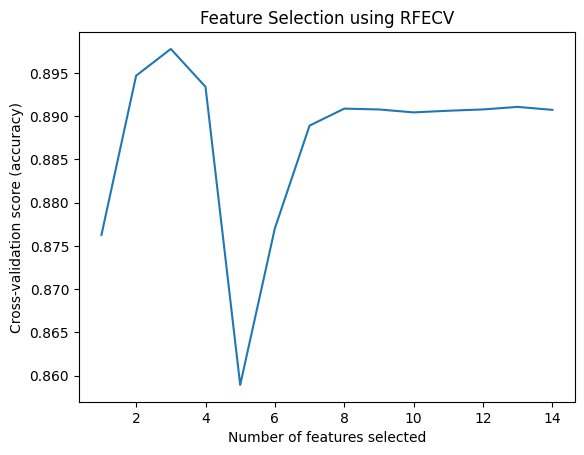

In [7]:
# add more lines to this plot for other models

# Get the mask of the selected features
selected_features = rfecv.support_

# Extract the names of the selected features
feature_names = X_train.columns.tolist()
selected_feature_names = np.array(feature_names)[selected_features]
print("Selected features:", selected_feature_names)

# Extract mean test scores from cv_results_
mean_scores = np.array(rfecv.cv_results_['mean_test_score'])

# Plot number of features VS. cross-validated scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.plot(range(1, len(mean_scores) + 1), mean_scores)
plt.title('Feature Selection using RFECV')
plt.show()

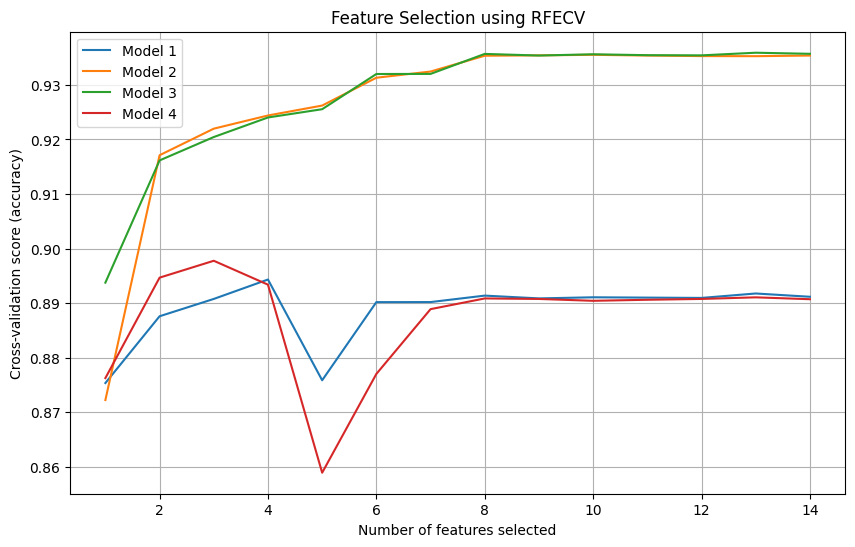

In [10]:
# plot all together
filenames = ['../crossvalidation/f2_tuned_features_RF.pkl',
            '../crossvalidation/features_RF.pkl',
            '../crossvalidation/tuned_features_RF.pkl',
            '../crossvalidation/f2_scaled_tuned_features_RF.pkl']

# Load all RFECV objects
rfecv_objects = []
for filename in filenames:
    with open(filename, 'rb') as file:
        rfecv = pickle.load(file)
        rfecv_objects.append(rfecv)

# Plotting setup
plt.figure(figsize=(10, 6))

for i, rfecv in enumerate(rfecv_objects):
    # Extract mean test scores
    mean_scores = np.array(rfecv.cv_results_['mean_test_score'])
    
    # Plot results
    plt.plot(range(1, len(mean_scores) + 1), mean_scores, label=f'Model {i+1}')

# Enhancing the plot
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.title('Feature Selection using RFECV')
plt.legend()
plt.grid(True)
plt.show()

optimal features baseline rf: 
Selected features: ['Fwd IAT Total' 'Fwd Packet Length Max' 'Bwd Packet Length Mean'
 'Bwd Packet Length Std' 'Bwd Packet Length Max' 'Packet Length Mean'
 'Packet Length Std' 'Packet Length Variance' 'Avg Packet Size'
 'Fwd Header Length']

optimal features tuned rf:
Selected features: ['Fwd IAT Total' 'Fwd Packet Length Max' 'Bwd Packet Length Mean'
 'Bwd Packet Length Std' 'Bwd Packet Length Max' 'Packet Length Max'
 'Packet Length Mean' 'Packet Length Std' 'Packet Length Variance'
 'Avg Packet Size' 'Fwd Header Length' 'Avg Fwd Segment Size'
 'Avg Bwd Segment Size']

optimal features f2:
    Selected features: ['Bwd Packet Length Mean' 'Bwd Packet Length Std' 'Packet Length Variance'
 'Avg Packet Size']

optimal features f2 scaled: 
Selected features: ['Bwd Packet Length Std' 'Packet Length Variance' 'Avg Packet Size']

Optimal number of features : 13


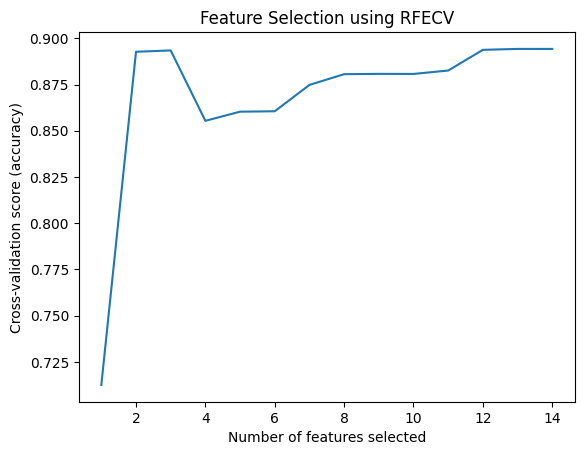

In [11]:

# Initialize the XGBoost classifier
#xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb = XGBClassifier(objective='binary:logistic', use_label_encoder=False,
colsample_bytree= 1.0, gamma = 0.5, learning_rate= 0.3, max_depth= 10, n_estimators= 350, subsample= 0.5, eval_metric='logloss')

# Define the scorer, F2 Score, could be too high, maybe experiment with F1.5
f2_scorer = make_scorer(fbeta_score, beta=2, average='binary')
# Create the RFE object with cross-validation
rfecv = RFECV(estimator=xgb, step=1, cv=StratifiedKFold(5), scoring=f2_scorer)
rfecv.fit(X_train, y_train)

# Extract mean test scores from cv_results_
print("Optimal number of features : %d" % rfecv.n_features_)
mean_scores = np.array(rfecv.cv_results_['mean_test_score'])

# Plot number of features VS. cross-validated scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.plot(range(1, len(mean_scores) + 1), mean_scores)
plt.title('Feature Selection using RFECV')
plt.show()

In [12]:
with open('../crossvalidation/f2_scaled_tuned_features_XGB.pkl', 'wb') as file:
    pickle.dump(rfecv, file)

In [13]:
# Get the mask of the selected features
selected_features = rfecv.support_

# Extract the names of the selected features
feature_names = X_train.columns.tolist()
selected_feature_names = np.array(feature_names)[selected_features]
print("Selected features:", selected_feature_names)

Selected features: ['Fwd IAT Total' 'Fwd Packet Length Max' 'Bwd Packet Length Mean'
 'Bwd Packet Length Std' 'Bwd Packets Length Total'
 'Bwd Packet Length Max' 'Packet Length Max' 'Packet Length Mean'
 'Packet Length Std' 'Packet Length Variance' 'Avg Packet Size'
 'Fwd Header Length' 'Avg Fwd Segment Size']


f1_tuned_xgb: 
Selected features: ['Fwd IAT Total' 'Fwd Packet Length Max' 'Bwd Packet Length Mean'
 'Bwd Packet Length Std' 'Bwd Packets Length Total'
 'Bwd Packet Length Max' 'Packet Length Max' 'Packet Length Mean'
 'Packet Length Std' 'Avg Packet Size' 'Fwd Header Length'
 'Avg Fwd Segment Size']

f2_tuned_scaled_xgb:
Selected features: ['Fwd IAT Total' 'Fwd Packet Length Max' 'Bwd Packet Length Mean'
 'Bwd Packet Length Std' 'Bwd Packets Length Total'
 'Bwd Packet Length Max' 'Packet Length Max' 'Packet Length Mean'
 'Packet Length Std' 'Packet Length Variance' 'Avg Packet Size'
 'Fwd Header Length' 'Avg Fwd Segment Size']

compare rfecv results to the internal evaluator in xgboost

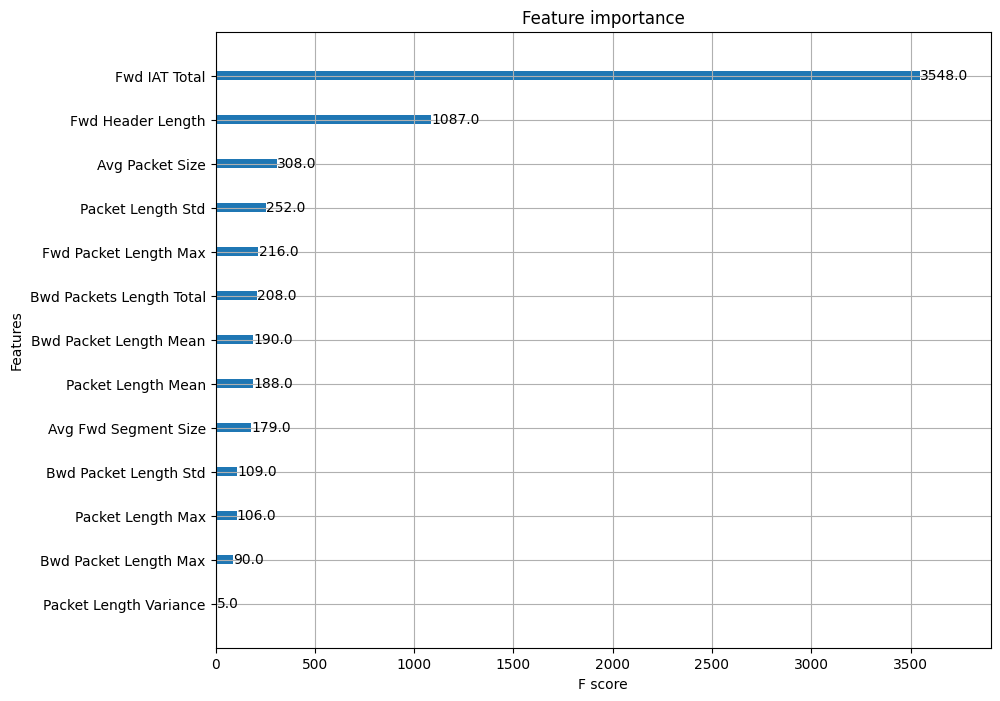

In [17]:

model = XGBClassifier(objective='binary:logistic', use_label_encoder=False,
colsample_bytree= 1.0, gamma = 0.5, learning_rate= 0.3, max_depth= 10, n_estimators= 350, subsample= 0.5, eval_metric='logloss')
model.fit(X_train, y_train)

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(model, ax=ax, importance_type='weight') # weight, gain
plt.show()

# permutation

In [22]:
# xgboost fitted
model = XGBClassifier(objective='binary:logistic', use_label_encoder=False,
colsample_bytree= 1.0, gamma = 0.5, learning_rate= 0.3, max_depth= 10, n_estimators= 350, subsample= 0.5, eval_metric='logloss')
model.fit(X_train, y_train)

# Define the F2 score as a custom scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

# permutate
result = permutation_importance(model, X_eval, y_eval, scoring=f2_scorer, n_repeats=10, random_state=42, n_jobs=-1)

# result.importances_mean provides the average decrease in model score due to the shuffling
feature_importance = result.importances_mean
for i in range(X_eval.shape[1]):
    print(f"Feature: {X_eval.columns[i]}, Importance: {feature_importance[i]}")

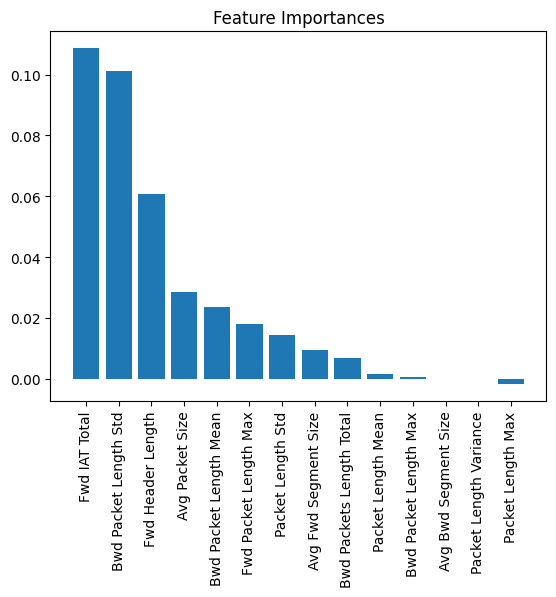

In [24]:
# plot sorted feature importance
indices = np.argsort(feature_importance)[::-1]  # Sort features by importance

plt.figure()
plt.title("Feature Importances")
plt.bar(range(X_eval.shape[1]), feature_importance[indices])
plt.xticks(range(X_eval.shape[1]), X_eval.columns[indices], rotation=90)
plt.show()

In [87]:
# RF fitted
model = RandomForestClassifier(n_estimators=110, max_depth = 40, min_samples_leaf=1,
                                        min_samples_split = 10, random_state=42)
model.fit(X_train, y_train)

# Define the F2 score as a custom scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

# permutate
result = permutation_importance(model, X_eval, y_eval, scoring=f2_scorer, n_repeats=10, random_state=42, n_jobs=-1)

# result.importances_mean provides the average decrease in model score due to the shuffling
feature_importance = result.importances_mean
for i in range(X_eval.shape[1]):
    print(f"Feature: {X_eval.columns[i]}, Importance: {feature_importance[i]}")

Feature: Fwd IAT Total, Importance: 0.09267820961771456
Feature: Fwd Packet Length Max, Importance: -0.0005827834099225826
Feature: Bwd Packet Length Mean, Importance: -0.0003059361529268778
Feature: Bwd Packet Length Std, Importance: 0.20925499809334652
Feature: Bwd Packets Length Total, Importance: 0.00727416902249497
Feature: Bwd Packet Length Max, Importance: -0.00011265088208790574
Feature: Packet Length Max, Importance: -0.0006188477522137026
Feature: Packet Length Mean, Importance: 0.0002402280153433356
Feature: Packet Length Std, Importance: -0.0006069125649813878
Feature: Packet Length Variance, Importance: -9.320078074341876e-05
Feature: Avg Packet Size, Importance: 0.013710933215950672
Feature: Fwd Header Length, Importance: 0.09002598277635673
Feature: Avg Fwd Segment Size, Importance: 0.008760848460596637
Feature: Avg Bwd Segment Size, Importance: 0.00022522155443535085


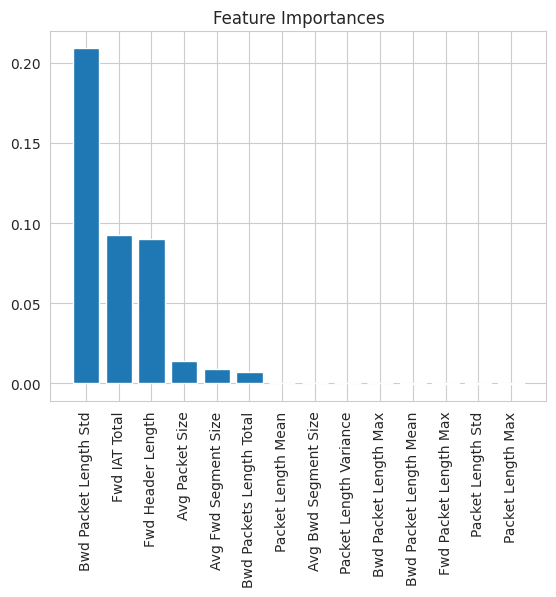

In [88]:
indices = np.argsort(feature_importance)[::-1]  # Sort features by importance

plt.figure()
plt.title("Feature Importances")
plt.bar(range(X_eval.shape[1]), feature_importance[indices])
plt.xticks(range(X_eval.shape[1]), X_eval.columns[indices], rotation=90)
plt.show()

# fit and compare models

In [83]:
def train_and_save(model, X_train, y_train, filename):
    """Train a model and save it to a specified filename."""
    model.fit(X_train, y_train)
    dump(model, filename)
    return model
    
def evaluate(model, X, y, model_name, feature_subset, beta=2):
    probabilities = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, probabilities)
    
    # Calculating F scores for the given beta
    f_scores = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    best_idx = np.nanargmax(f_scores)  # Using nanargmax to ignore NaNs in the calculation
    best_threshold = thresholds[best_idx]
    predictions = (probabilities >= best_threshold).astype(int)
    
    # Calculate metrics
    acc = accuracy_score(y, predictions)
    prec = precision_score(y, predictions, zero_division=0)
    rec = recall_score(y, predictions, zero_division=0)
    f1 = f1_score(y, predictions, zero_division=0)
    f2 = (1 + 2**2) * (prec * rec) / ((2**2 * prec + rec))
    roc_auc = roc_auc_score(y, probabilities)

    # Store performances
    performances.append({
        'model': model_name + '_' + str(len(feature_subset)),
        'features': feature_subset,
        'threshold': best_threshold,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'f2': f2,
        'roc_auc': roc_auc,
        'beta': beta
    })
    
    report = classification_report(y, predictions)
    cm = confusion_matrix(y, predictions)

    # Save the classification report as TXT
    report_path = f'../models/feature_test/{model_name}_classification_report.txt'
    with open(report_path, 'w') as f:
        f.write(report)

    # Generate and save onfusion matrix as JPEG
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'Confusion Matrix for {model_name}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_xticklabels(['Negative', 'Positive'])
    ax.set_yticklabels(['Negative', 'Positive'])
    plt.tight_layout()
    
    matrix_path = f'../models/feature_test/{model_name}_confusion_matrix.jpeg'
    plt.savefig(matrix_path)
    plt.close(fig)
    print(f"Saved confusion matrix for {model_name} at {matrix_path}")

def test_feature_subsets(model, feature_subset, X_train, y_train, X_eval, y_eval, model_name):
    X_train_subset = X_train[feature_subset]
    X_eval_subset = X_eval[feature_subset]

    filename = f"../models/feature_test/{model_name}.joblib"
    trained_model = train_and_save(model, X_train_subset, y_train, filename) # fitting the subset
    evaluate(trained_model, X_eval_subset, y_eval, f"{model_name}", feature_subset)
    return

In [100]:
# Selecting features with non-negative importance > 0.01
#feature_subset = [feat for feat, imp in importance_scores.items() if imp > 0.01]

all_features = ['Fwd IAT Total', 'Fwd Packet Length Max',
        'Bwd Packet Length Mean', 'Bwd Packet Length Std',
        'Bwd Packets Length Total', 'Bwd Packet Length Max',
        'Packet Length Max', 'Packet Length Mean', 'Packet Length Std',
        'Packet Length Variance', 'Avg Packet Size', 'Fwd Header Length',
        'Avg Fwd Segment Size', 'Avg Bwd Segment Size']
        
xgb_feature_subset_permutation = ['Fwd IAT Total', 'Fwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
 'Packet Length Std', 'Avg Packet Size', 'Fwd Header Length']
xgb_feature_subset_rfecv = ['Fwd IAT Total', 'Fwd Packet Length Max', 'Bwd Packet Length Mean', 'Bwd Packet Length Std',
 'Bwd Packets Length Total','Bwd Packet Length Max', 'Packet Length Max', 'Packet Length Mean',
 'Packet Length Std', 'Packet Length Variance', 'Avg Packet Size', 'Fwd Header Length', 'Avg Fwd Segment Size']

rf_feature_subset_rfecv =  ['Bwd Packet Length Std', 'Packet Length Variance', 'Avg Packet Size']
rf_feature_subset_permutation = ['Bwd Packet Length Std', 'Fwd IAT Total', 'Fwd Header Length', 'Avg Packet Size']
rf_feature_subset_perm_pos = ['Fwd IAT Total', 'Bwd Packet Length Std', 'Bwd Packets Length Total',
 'Packet Length Mean','Avg Packet Size', 'Fwd Header Length', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size']

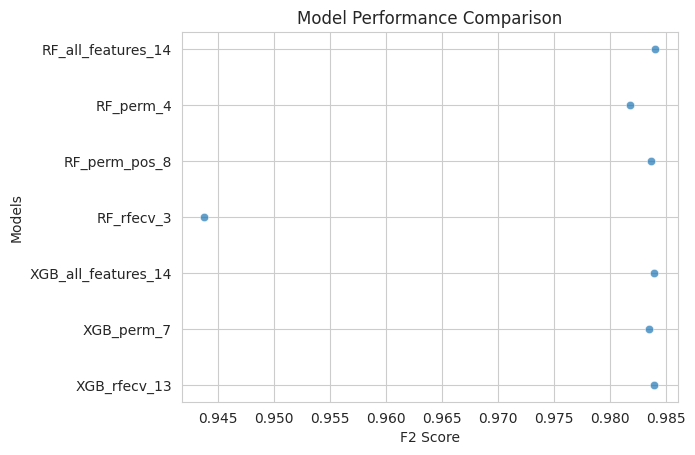

In [8]:
perf_df = plot_model_performance(perf_df, metric='f2') # rf14

In [101]:
performances = []

# XGBoost
xgb_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False,
colsample_bytree= 1.0, gamma = 0.5, learning_rate= 0.3, max_depth= 10, n_estimators= 350, subsample= 0.5, eval_metric='logloss')

test_feature_subsets(xgb_model, xgb_feature_subset_permutation, X_train, y_train, X_eval, y_eval, model_name = 'XGB_perm')
test_feature_subsets(xgb_model, xgb_feature_subset_rfecv, X_train, y_train, X_eval, y_eval, model_name = 'XGB_rfecv')
test_feature_subsets(xgb_model, all_features, X_train, y_train, X_eval, y_eval, model_name = 'XGB_all_features')


Saved confusion matrix for XGB_perm at ../models/feature_test/XGB_perm_confusion_matrix.jpeg
Saved confusion matrix for XGB_rfecv at ../models/feature_test/XGB_rfecv_confusion_matrix.jpeg
Saved confusion matrix for XGB_all_features at ../models/feature_test/XGB_all_features_confusion_matrix.jpeg


In [102]:
# random forest
rf_model = RandomForestClassifier(n_estimators=110, max_depth = 40, min_samples_leaf=1,
                                        min_samples_split = 10, random_state=42)

test_feature_subsets(rf_model, rf_feature_subset_permutation, X_train, y_train, X_eval, y_eval, model_name = 'RF_perm')
test_feature_subsets(rf_model, rf_feature_subset_rfecv, X_train, y_train, X_eval, y_eval, model_name = 'RF_rfecv')
test_feature_subsets(rf_model, rf_feature_subset_perm_pos, X_train, y_train, X_eval, y_eval, model_name = 'RF_perm_pos')
test_feature_subsets(rf_model, all_features, X_train, y_train, X_eval, y_eval, model_name = 'RF_all_features')


Saved confusion matrix for RF_perm at ../models/feature_test/RF_perm_confusion_matrix.jpeg
Saved confusion matrix for RF_rfecv at ../models/feature_test/RF_rfecv_confusion_matrix.jpeg
Saved confusion matrix for RF_perm_pos at ../models/feature_test/RF_perm_pos_confusion_matrix.jpeg
Saved confusion matrix for RF_all_features at ../models/feature_test/RF_all_features_confusion_matrix.jpeg


In [104]:
perf_df = pd.DataFrame(performances)
perf_df.to_csv('../output/feature_reduction_results.csv', index = False)

In [4]:
perf_df = pd.read_csv('../output/feature_reduction_results.csv')

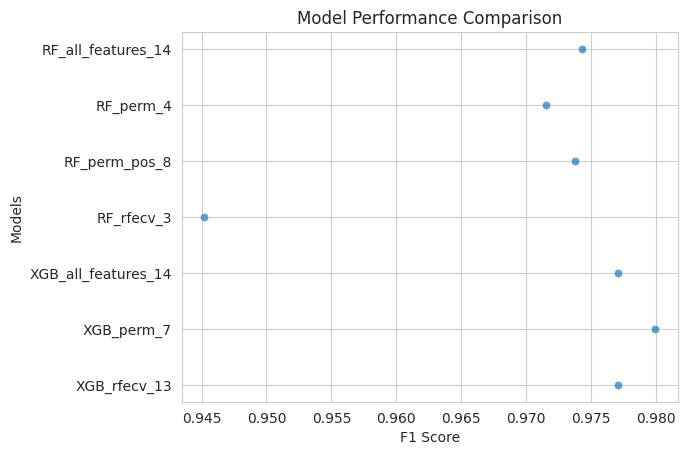

In [6]:
def plot_model_performance(perf_df, metric='f2'):
    #perf_df = pd.DataFrame(performances)
    
    # sort the full DataFrame based on the order of the test set performance
    perf_df['model'] = pd.Categorical(perf_df['model'], ordered=True)
    #perf_df = perf_df.sort_values('model')

    # Set up the plot
    sns.set_style('whitegrid')
    scatter_plot = sns.scatterplot(data=perf_df, 
                                   x=metric, 
                                   y='model',
                                   alpha=0.7)

    scatter_plot.set_title('Model Performance Comparison')
    scatter_plot.set_xlabel(f'{metric.capitalize()} Score')
    scatter_plot.set_ylabel('Models')
    plt.show()
    return perf_df

In [106]:
perf_df

,model,features,threshold,accuracy,precision,recall,f1,f2,roc_auc,beta
0,XGB_perm_7,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.828708,0.993967,0.973992,0.985944,0.979931,0.983530,0.999311,2
1,XGB_rfecv_13,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.783102,0.993067,0.965780,0.988621,0.977067,0.983967,0.999330,2
2,XGB_all_features_14,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.783102,0.993067,0.965780,0.988621,0.977067,0.983967,0.999330,2
3,RF_perm_4,"[Bwd Packet Length Std, Fwd IAT Total, Fwd Hea...",0.606717,0.991333,0.954761,0.988844,0.971504,0.981834,0.998887,2
4,RF_rfecv_3,"[Bwd Packet Length Std, Packet Length Variance...",0.556640,0.983667,0.947534,0.942883,0.945202,0.943809,0.994873,2
5,RF_perm_pos_8,"[Fwd IAT Total, Bwd Packet Length Std, Bwd Pac...",0.610204,0.992033,0.957713,0.990406,0.973785,0.983690,0.998933,2
6,RF_all_features_14,"[Fwd IAT Total, Fwd Packet Length Max, Bwd Pac...",0.629748,0.992200,0.958549,0.990629,0.974325,0.984043,0.998995,2


In [56]:
results

[{'model': 'XGB_0_beta2',
  'features': ['Fwd IAT Total',
   'Fwd Packet Length Max',
   'Bwd Packet Length Mean',
   'Bwd Packet Length Std',
   'Packet Length Std',
   'Avg Packet Size',
   'Fwd Header Length'],
  'threshold': 0.8287079,
  'accuracy': 0.9939666666666667,
  'precision': 0.9739916244214238,
  'recall': 0.9859437751004017,
  'f1': 0.9799312562368333,
  'f2': array([4.67576365e-01, 4.67586121e-01, 4.67654424e-01, ...,
         3.34448161e-03, 2.78877796e-04, 0.00000000e+00]),
  'roc_auc': 0.9993107471818459}]